# Procrastinate Pro+

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания "Procrastinate Pro+" терпит убытки. Задача — разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
* лог сервера с данными об их посещениях,
* выгрузка их покупок за этот период,
* рекламные расходы.


Необходимо изучить:
* откуда приходят пользователи и какими устройствами они пользуются,
* сколько стоит привлечение пользователей из различных рекламных каналов;
* сколько денег приносит каждый клиент,
* когда расходы на привлечение клиента окупаются,
* какие факторы мешают привлечению клиентов.

## Загрузка данных и подготовка их к анализу

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

visits.info()
display(visits.head(5))
orders.info()
display(orders.head(5))
costs.info()
display(costs.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Предварительный анализ таблиц:
* Названия столбцов не приведены к snake_case;
* Пропусков нет ни в одной таблице;
* Все даты имеют тип данных "object", необходимо будет заменить его на "datetime";
* Необходимо проверить данные на наличие дубликатов.

In [3]:
visits.columns = visits.columns.str.lower()
visits.columns = visits.columns.str.replace(' ', '_')
visits.columns

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

In [4]:
orders.columns = orders.columns.str.lower()
orders.columns = orders.columns.str.replace(' ', '_')
orders.columns

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

In [5]:
costs.columns = costs.columns.str.lower()
costs.columns

Index(['dt', 'channel', 'costs'], dtype='object')

In [6]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [7]:
print('Количество дубликатов в таблице "visits":', visits.duplicated().sum()) 
print('Количество дубликатов в таблице "orders":', orders.duplicated().sum()) 
print('Количество дубликатов в таблице "costs":', costs.duplicated().sum()) 

Количество дубликатов в таблице "visits": 0
Количество дубликатов в таблице "orders": 0
Количество дубликатов в таблице "costs": 0


Вследствие предобработки данных:
* Названия столбцов приведены к snake_case;
* Тип данных с датами изменён на более подходящий "datetime";
* Дубликатов в данных не оказалось.

## Задание функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [8]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [9]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [10]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [11]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [12]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [13]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [14]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [15]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

In [16]:
profiles = get_profiles(visits, orders, None, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [17]:
min_date = profiles['dt'].min()
print('Минимальная дата привлечения пользователей:', min_date)

Минимальная дата привлечения пользователей: 2019-05-01


In [18]:
max_date = profiles['dt'].max()
print('Максимальная дата привлечения пользователей:', max_date)

Максимальная дата привлечения пользователей: 2019-10-27


**Вывод:**
* Минимальная дата привлечения пользователей: 2019-05-01;
* Максимальная дата привлечения пользователей: 2019-10-27.

In [19]:
grouped_region = (profiles.groupby('region')
                          .agg({'user_id': 'nunique',
                                'payer': 'sum'})
                          .rename(columns={'user_id': 'unique_users'}))
grouped_region['percent'] = grouped_region['payer'] / grouped_region['unique_users'] * 100
grouped_region

,unique_users,payer,percent
region,,,
France,17450,663,3.799427
Germany,14981,616,4.111875
UK,17575,700,3.982930
United States,100002,6902,6.901862


**Вывод:**
* Большинство пользователей живёт в США. Меньше всего пользователей в Германии;
* Большинство платящих пользователей живёт в США. Наименьшее число платящих пользователей в Германии;
* Наибольшаяя доля платящих пользователей в США (6.9%), наименьшая доля платящих пользователей во Франции (3.8%).

In [20]:
grouped_device = (profiles.groupby('device')
                          .agg({'user_id': 'nunique',
                               'payer': 'sum'})
                          .rename(columns={'user_id':'unique_users'}))
grouped_device['percent'] = grouped_device['payer'] / grouped_device['unique_users'] * 100
grouped_device

,unique_users,payer,percent
device,,,
Android,35032,2050,5.851793
Mac,30042,1912,6.364423
PC,30455,1537,5.046790
iPhone,54479,3382,6.207897


**Вывод:**
* Большинство пользователей используют IPhone. Меньше всего пользователей MAC и PC;
* Большинство платящих пользователей используют IPhone. Наименьшее число платящих пользователей используют PC;
* Наибольшаяя доля платящих пользователей используют MAC (6.3%) и IPhone (6.2%), наименьшая доля платящих пользователей используют PC (5%).

In [21]:
grouped_channel = (profiles.groupby('channel')
                           .agg({'user_id': 'nunique',
                                'payer': 'sum'})
                           .rename(columns={'user_id':'unique_users'}))
grouped_channel['percent'] = grouped_channel['payer'] / grouped_channel['unique_users'] * 100
grouped_channel

,unique_users,payer,percent
channel,,,
AdNonSense,3880,440,11.340206
FaceBoom,29144,3557,12.204914
LeapBob,8553,262,3.063253
MediaTornado,4364,156,3.574702
OppleCreativeMedia,8605,233,2.707728
RocketSuperAds,4448,352,7.913669
TipTop,19561,1878,9.600736
WahooNetBanner,8553,453,5.296387
YRabbit,4312,165,3.826531


**Вывод:**
* Большинство пользователей появилось само (т.е. из канала "organic");
* Самые популярные каналы для привлечения оказались "FaceBoom" и "TipTop". Меньше всего появилось пользователей из "LambdaMediaAds";
* Большинство платящих пользователей пришло из "FaceBoom" и "TipTop". Меньше всего появилось пользователей из "MediaTornado" и "YRabbit";
* Наибольшаяя доля платящих пользователей пришло из "FaceBoom" (12.2%), "AdNonSense" (11.3%) и "LambdaMediaAds" (10.5%), наименьшая доля платящих пользователей пришло самостоятельно (2%) и "OppleCreativeMedia" (2.7%).

## Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

In [22]:
print('Траты на рекламу с 01.05.2019 по 27.10.2019:', costs['costs'].sum())

Траты на рекламу с 01.05.2019 по 27.10.2019: 105497.30000000002


,costs
channel,
YRabbit,944.22
MediaTornado,954.48
lambdaMediaAds,1557.60
LeapBob,1797.60
RocketSuperAds,1833.00
OppleCreativeMedia,2151.25
AdNonSense,3911.25
WahooNetBanner,5151.00
FaceBoom,32445.60


<AxesSubplot:title={'center':'Стоимость рекламы в источнике за всё время'}, xlabel='Источник привлечения пользователей', ylabel='Затараты на рекламу'>

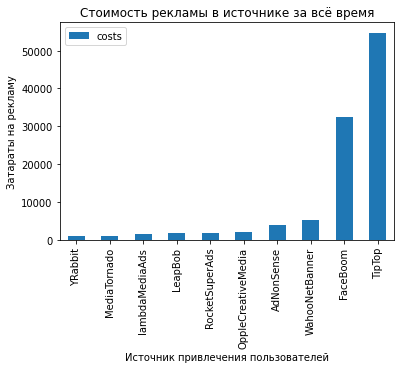

In [24]:
costs_pie = costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs')
display(costs_pie)
costs_pie.plot(kind='bar', 
               xlabel='Источник привлечения пользователей', 
               ylabel='Затараты на рекламу', 
               title='Стоимость рекламы в источнике за всё время')

<AxesSubplot:title={'center':'Доли трат на рекламу'}, ylabel='costs'>

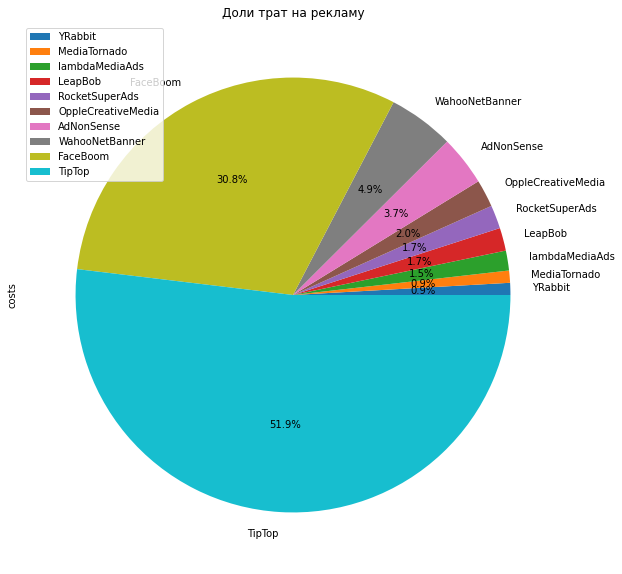

In [25]:
costs_pie['costs'].plot(kind='pie', 
                        autopct='%1.1f%%',  
                        legend=True, 
                        figsize=(20, 10), 
                        title='Доли трат на рекламу')

**Вывод:**
* На диаграммах видно, что больший бюджет рекламы уходит на рекламу в TipTop (51.9%) и FaceBoom (30.8%)

Text(0.5, 1.0, 'Динамика изменения расходов на рекламу')

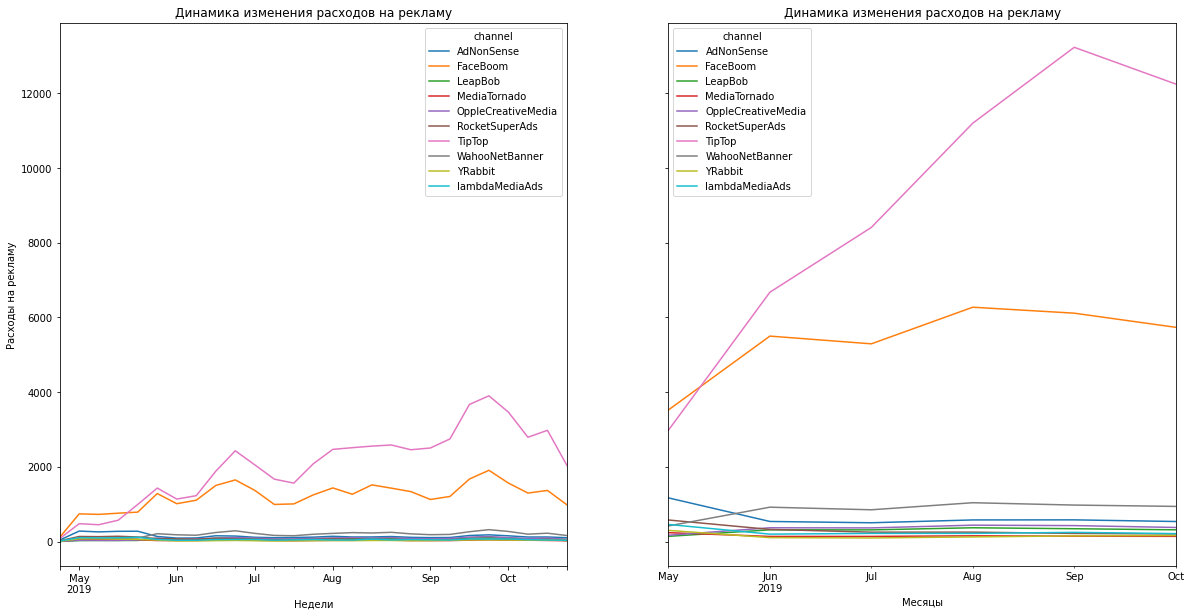

In [40]:
grouped_costs = costs
grouped_costs['week'] = grouped_costs['dt'].astype('datetime64[W]')
grouped_costs['month'] = grouped_costs['dt'].astype('datetime64[M]')

ax1 = plt.subplot(1, 2, 1)

grouped_costs_week = pd.pivot_table(grouped_costs,
                               index='channel', 
                               columns='week', 
                               values='costs', 
                               aggfunc='sum').T.plot(ax=ax1, figsize=(20, 10))
plt.xlabel('Недели')
plt.ylabel('Расходы на рекламу')
plt.title('Динамика изменения расходов на рекламу')

ax2 = plt.subplot(1, 2, 2, sharey=ax1)

grouped_costs_month = pd.pivot_table(grouped_costs,
                               index='channel', 
                               columns='month', 
                               values='costs', 
                               aggfunc='sum').T.plot(ax=ax2, figsize=(20, 10))
plt.xlabel('Месяцы')
plt.ylabel('Расходы на рекламу')
plt.title('Динамика изменения расходов на рекламу')

**Вывод:**
* Судя по графикам динамики изменения расходов на рекламу по неделям и месяцам, отдел маркетинга считает FaceBoom и TipTop самыми перспективными для привелчения пользователей, поэтому вкладывает больше денег на рекламу в этих ресурсах.

,unique_users,costs,cac
channel,,,
TipTop,19561,54751.30,2.799003
FaceBoom,29144,32445.60,1.113286
AdNonSense,3880,3911.25,1.008054
lambdaMediaAds,2149,1557.60,0.724802
WahooNetBanner,8553,5151.00,0.602245
RocketSuperAds,4448,1833.00,0.412095
OppleCreativeMedia,8605,2151.25,0.250000
YRabbit,4312,944.22,0.218975
MediaTornado,4364,954.48,0.218717


<AxesSubplot:xlabel='channel'>

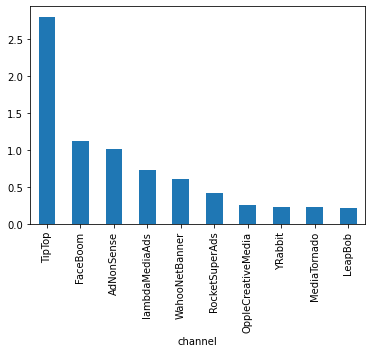

In [44]:
avg_price_for_user = grouped_channel.merge(costs.groupby('channel').agg({'costs': 'sum'}), on='channel')
avg_price_for_user['cac'] = avg_price_for_user['costs'] / avg_price_for_user['unique_users']
avg_price_for_user = avg_price_for_user.drop(columns=['payer', 'percent']).sort_values(by='cac', ascending=False)
display(avg_price_for_user)
avg_price_for_user['cac'].plot(kind='bar')

**Вывод:**
* Стоимость привлечения пользователей через TipTop почти в 2.5 раза выше, чем стомость привлечения через второй по стоимости канал FaceBoom.

## Оценка окупаемости рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

In [66]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14
profiles = profiles[profiles['channel'] != 'organic']

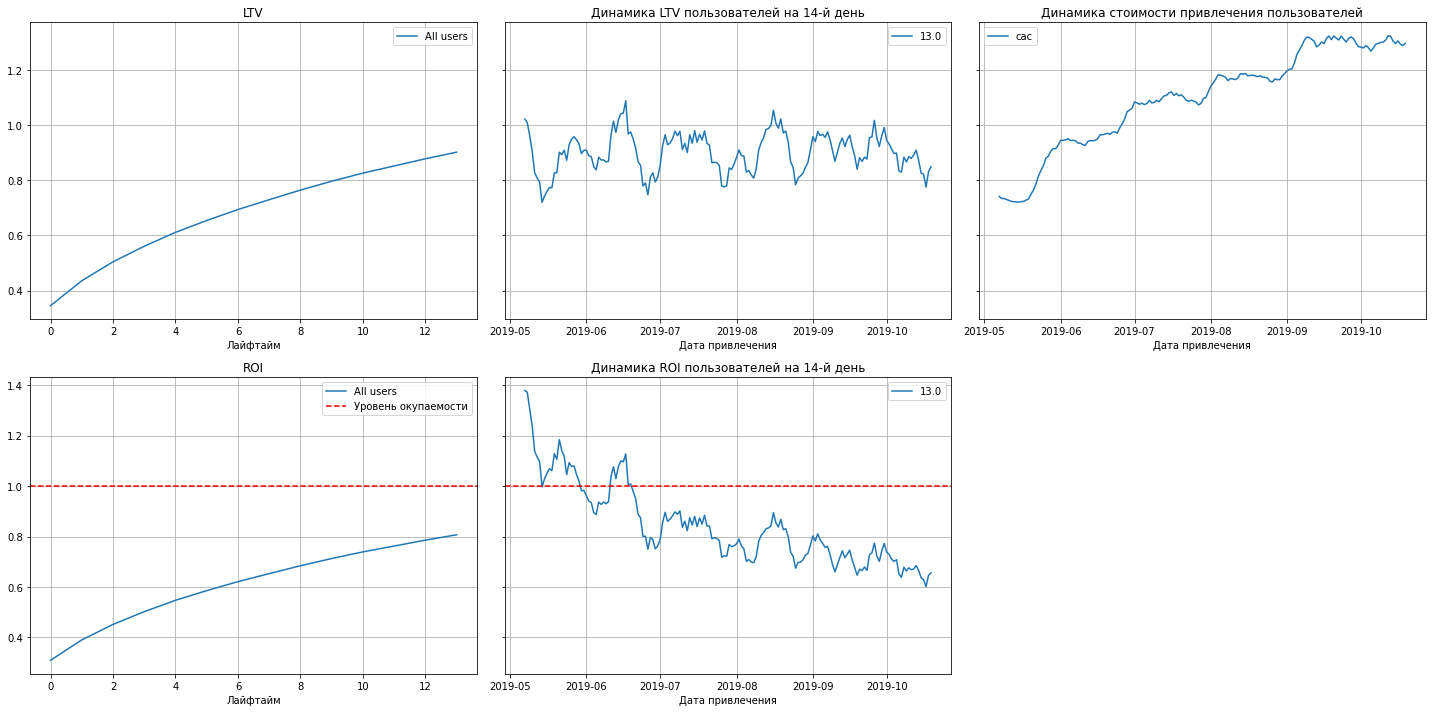

In [67]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles, 
                                                                      orders, 
                                                                      observation_date, 
                                                                      horizon_days)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

**Вывод:**
* CAC постоянно растёт;
* ROI к концу недели не пересекает уровень окупаемости, следовательно реклама не окупется;
* На графике динамики ROI видно, что показатели падают. Это связано с увеличением расходов на неокупаемую рекламу.

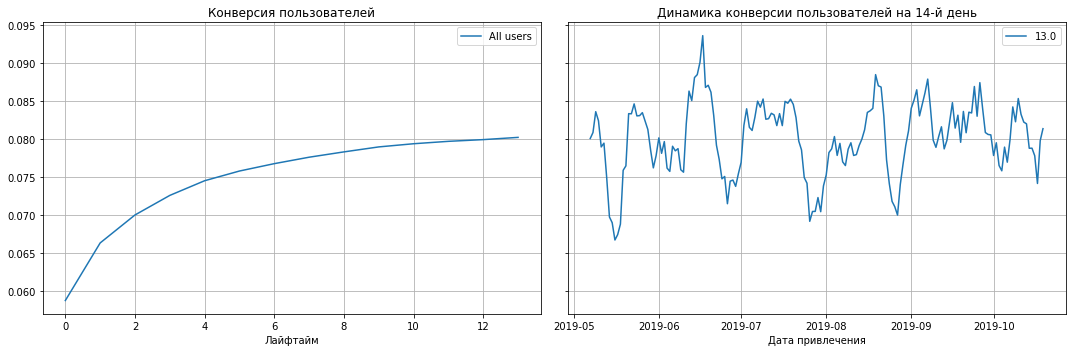

In [68]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, 
                                                                        orders, 
                                                                        observation_date, 
                                                                        horizon_days)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Общая конверсия выглядит хорошо.

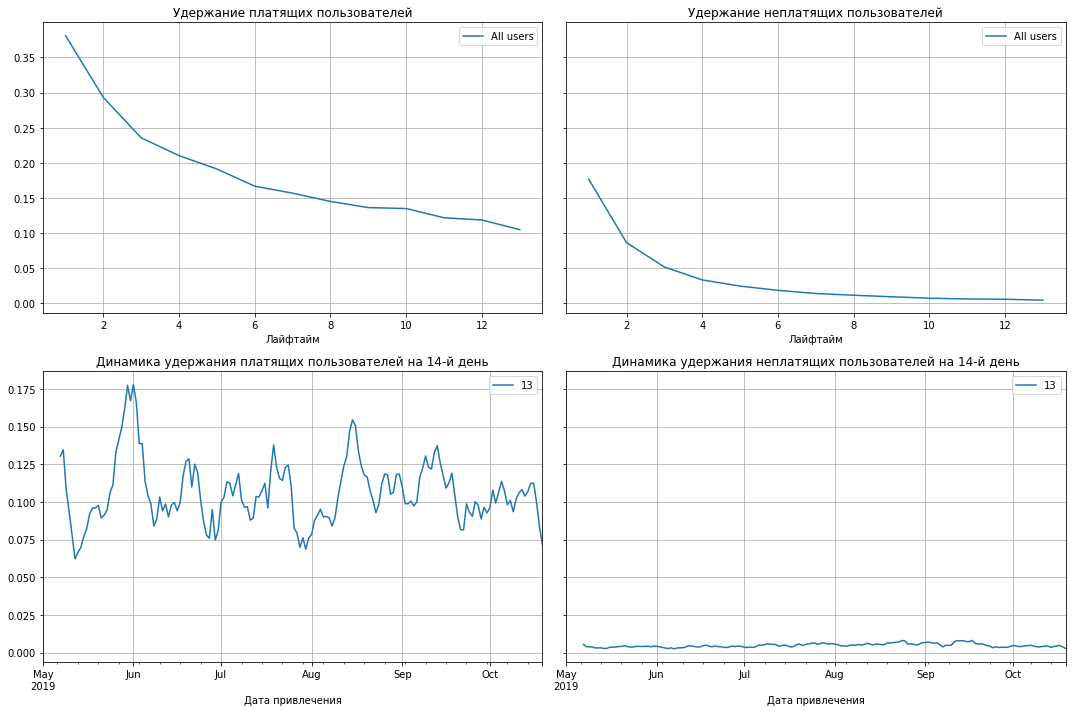

In [69]:
retention_raw, retention_grouped, retention_history = get_retention(profiles, 
                                                                    visits, 
                                                                    observation_date, 
                                                                    horizon_days)

plot_retention(retention_grouped, retention_history, horizon_days)

Общее удержание как платящих, так и неплатящих пользователей в порядке.

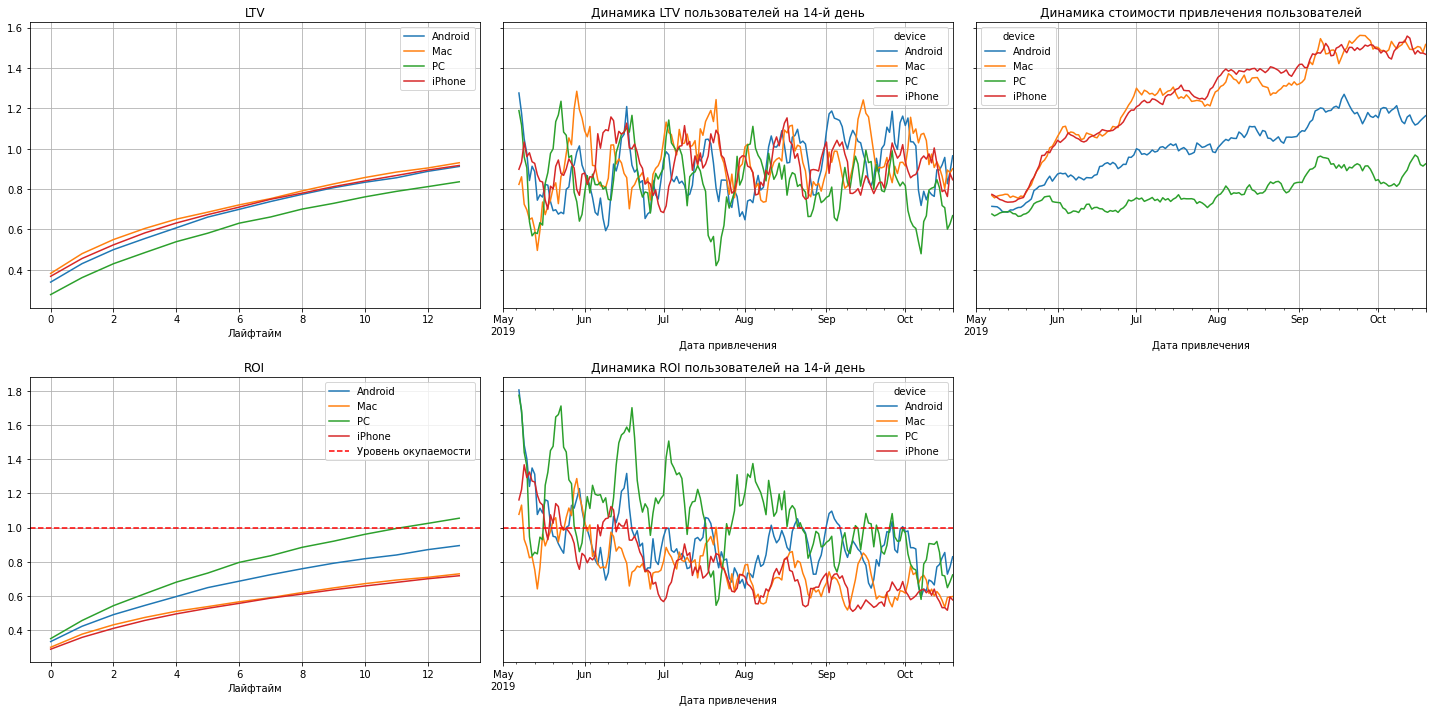

In [70]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles, 
                                                                      orders, 
                                                                      observation_date, 
                                                                      horizon_days, 
                                                                      dimensions=['device'])

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

**Вывод:**
* Стоимость привлечения пользователей IPhone и MAC выше, чем стоимость привелечия пользователей Android и PC;
* Пользователи IPhone и MAC не достигают уровня окупаемости.
* В целом графики выглядят одинаково, так что вряд ли неокупаемость рекламы зависит от устройства.

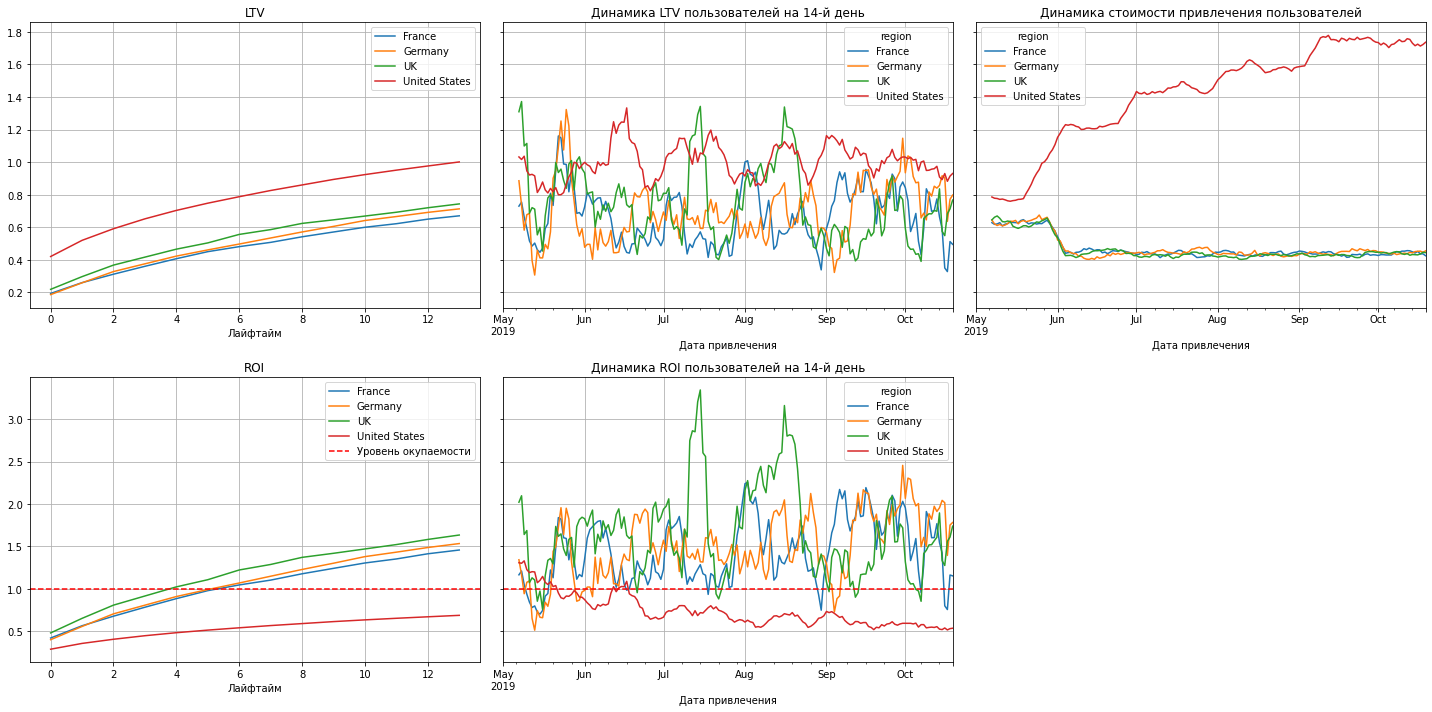

In [71]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles, 
                                                                      orders, 
                                                                      observation_date, 
                                                                      horizon_days, 
                                                                      dimensions=['region'])

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

**Вывод:**
* Стоимость привлечения пользователей из США растёт гораздо выше, чем стоимость привелечия пользователей из других стран;
* Пользователи из США не достигают уровня окупаемости, в отличие от пользователей из других стран;
* ROI пользователей из США падает с каждым месяцем, в отличие от ROI пользователей из других стран.

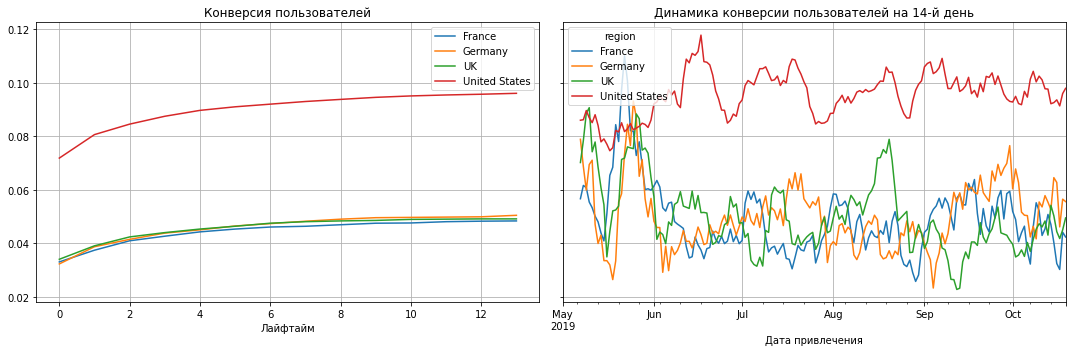

In [72]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, 
                                                                        orders, 
                                                                        observation_date, 
                                                                        horizon_days, 
                                                                        dimensions=['region'])

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Пользователи из США конвертируются гораздо лучше, чем пользователи из других стран.

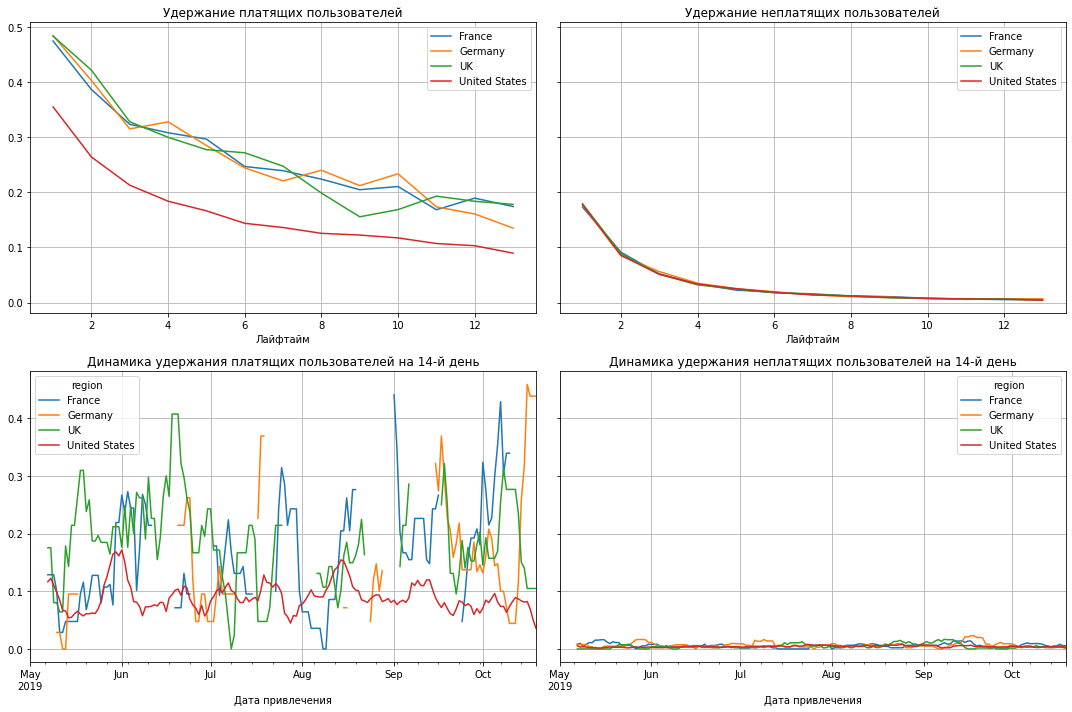

In [73]:
retention_raw, retention_grouped, retention_history = get_retention(profiles, 
                                                                    visits, 
                                                                    observation_date, 
                                                                    horizon_days, dimensions=['region'])

plot_retention(retention_grouped, retention_history, horizon_days)

Платящие пользователи из США удерживаются ненамного хуже, чем платящие пользователи из других стран.

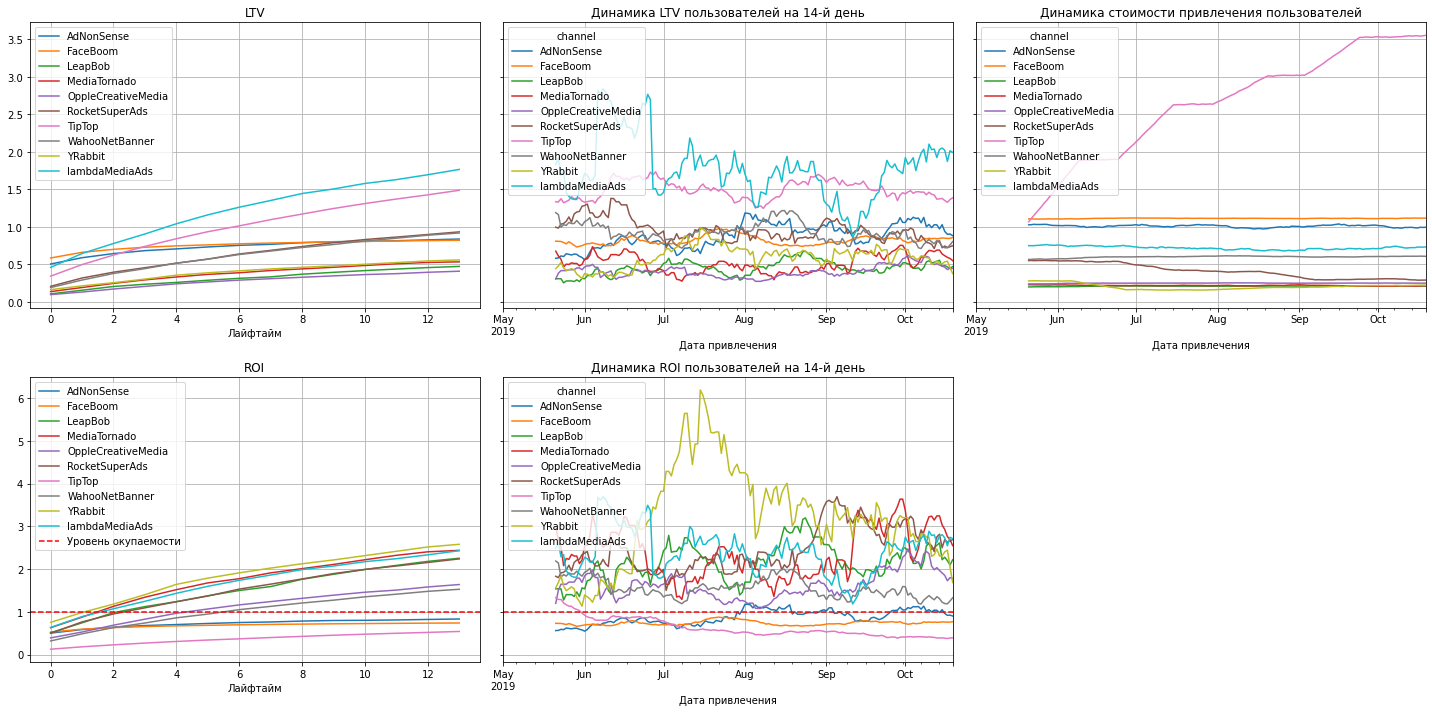

In [75]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles, 
                                                                      orders, 
                                                                      observation_date, 
                                                                      horizon_days, 
                                                                      dimensions=['channel'])

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=21) 

**Вывод:**
* Реклама через FaceBoom и TipTop не окупается;
* Стоимость привлечения новых пользователей через TipTop постоянно растёт.

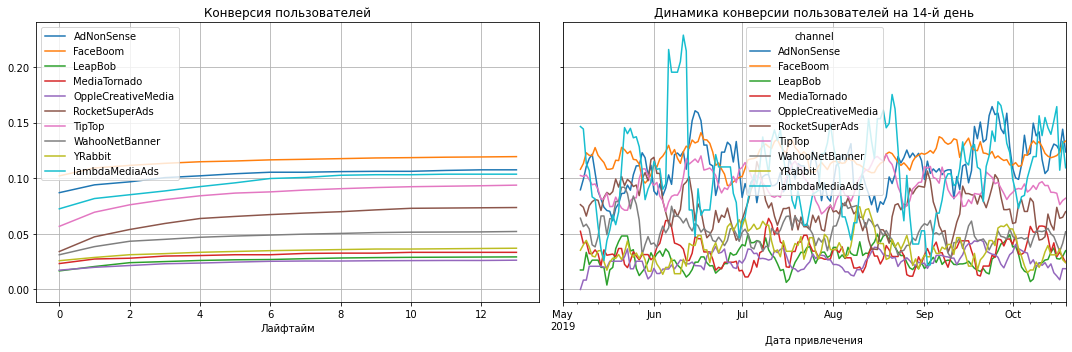

In [76]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, 
                                                                        orders, 
                                                                        observation_date, 
                                                                        horizon_days, 
                                                                        dimensions=['channel'])

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Пользователи почти одинаково ковертируются из всех каналов привлечения.

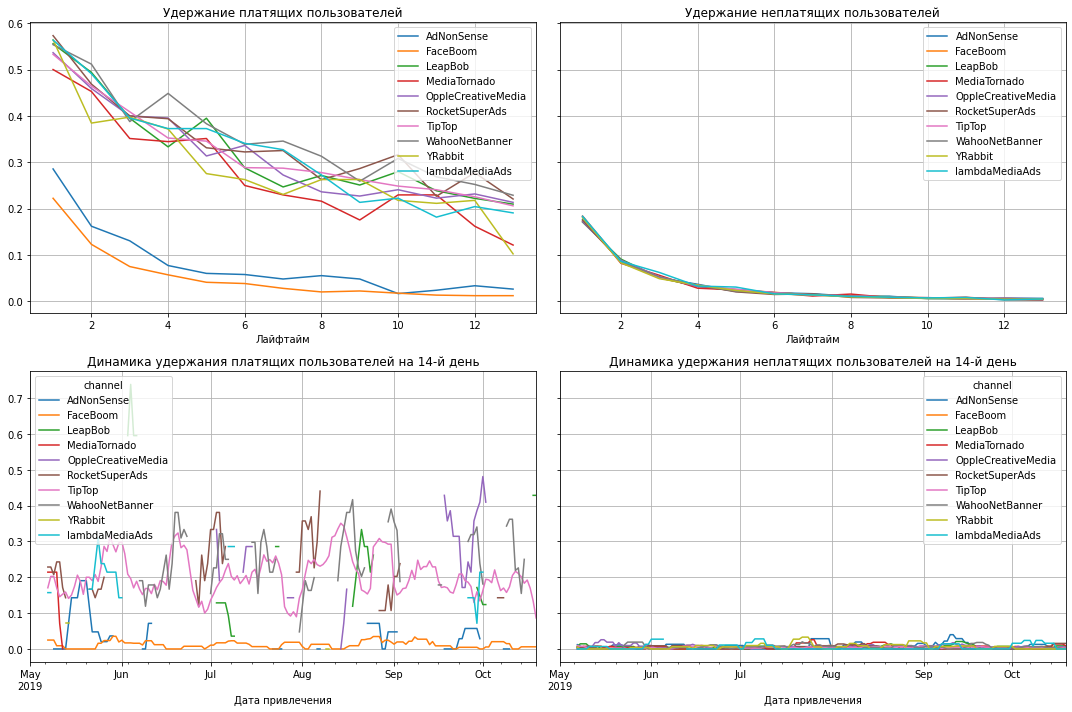

In [77]:
retention_raw, retention_grouped, retention_history = get_retention(profiles, 
                                                                    visits, 
                                                                    observation_date, 
                                                                    horizon_days, 
                                                                    dimensions=['channel'])

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание пользователей, привлечённых через FaceBoom, самое низкое.

### Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

Проведя обширное исследование я пришёл к следующим выводам:
* Большая часть бюджета уходит на рекламу в FaceBoom и TipTop (порядка 80%);
* Расходы на рекламу в TipTop постоянно растут;
* Реклама в FaceBoom приносит слабый результат: платящие пользователи не задерживаются;
* Пользователи из США обходятся гораздо дороже чем пользователи из других стран.

In [78]:
pd.pivot_table(profiles.query('region == "United States"'), columns='channel', values='user_id', aggfunc='count')

channel,FaceBoom,MediaTornado,RocketSuperAds,TipTop,YRabbit
user_id,29144,4364,4448,19561,4312


Как оказалось в ходе исследования, пользователи из США гораздо лучше конвертируются, следовательно больше способны принести прибыли. Основные каналы привелечения этих пользователей представлены в таблице выше. Проблема в том, что удержание пользователей, привеченных через FaceBoom хуже всех остальных источников, хотя и конверсия этих пользователей выше.

Реклама плохо окупается. Большая часть рекламного бюджета расходуется неэфективно. Скорее всего, если убрать рекламу из FaceBoom и AdNonSense (т.к. удержание пользователей, привлечённых через эти каналы минимально), снизить расходы на рекламу в TipTop, перераспределить бюджет между оставшимися каналами рекламы, то можно будет увидеть положительный результат в виде увеличения прибыли. Также, вероятно пользователи из США обходятся так дорого, потому что для их привлечения используются неэфективные каналы привлечения, и это может исправить перераспределение рекламного бюджета. Возможно, стоит рассмотреть каналы MediaTornado, RocketSuperAds и YRabbit